# 3D Rayleigh-Bénard: Equivariant Convolutional Autoencoder

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append('..')

from utils import data_reader
from utils.data_augmentation import DataAugmentation
from torch.utils.data import DataLoader
from utils import training
from utils.evaluation import compute_test_loss
from utils.visualization import auto_encoder_animation
from IPython.display import Video

import escnn
from escnn import gspaces

2025-01-04 20:25:14.438981: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-04 20:25:14.471965: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-04 20:25:15.025423: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import torch, numpy as np, random
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.set_device(0)
    DEVICE = torch.cuda.current_device()
    print('Current device:', torch.cuda.get_device_name(DEVICE))
else:
    print('Failed to find GPU. Will use CPU.')
    DEVICE = 'cpu'

Current device: NVIDIA A100 80GB PCIe


## Data

In [3]:
BATCH_SIZE = 64

SIMULATION_NAME = 'x48_y48_z32_Ra2500_Pr0.7_t0.01_snap0.125_dur300'

HORIZONTAL_SIZE = int(SIMULATION_NAME.split('_')[0][1:])
HEIGHT = int(SIMULATION_NAME.split('_')[2][1:])

In [4]:
sim_file = os.path.join('..', 'data', 'datasets', f'{SIMULATION_NAME}.h5')

N_train_avail, N_valid_avail, N_test_avail = data_reader.num_samples(sim_file, ['train', 'valid', 'test'])

# Reduce the amount of data manually
N_TRAIN = N_train_avail # TODO may change
N_VALID = N_valid_avail # TODO may change
N_TEST = N_test_avail # TODO may change

train_dataset = data_reader.DataReader(sim_file, 'train', device=DEVICE, shuffle=True, samples=N_TRAIN)
valid_dataset = data_reader.DataReader(sim_file, 'valid', device=DEVICE, shuffle=True, samples=N_VALID)
test_dataset = data_reader.DataReader(sim_file, 'test', device=DEVICE, shuffle=True, samples=N_TEST)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=0, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=0, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=0, drop_last=False)

print(f'Using {N_TRAIN}/{N_train_avail} training samples')
print(f'Using {N_VALID}/{N_valid_avail} validation samples')
print(f'Using {N_TEST}/{N_test_avail} testing samples')

Using 24060/24060 training samples
Using 8020/8020 validation samples
Using 8020/8020 testing samples


## Model Definition

#### Hyperparameters

In [5]:
H_KERNEL_SIZE, V_KERNEL_SIZE = 3, 5
DROP_RATE = 0.2
NONLINEARITY, STEERABLE_NONLINEARITY = torch.nn.ELU, escnn.nn.ELU

LEARNING_RATE = 1e-3
LR_DECAY = 0.1
LR_DECAY_EPOCHS = [10] # epochs at which the learning rate is multiplied by LR_DECAY
USE_LR_SCHEDULER = False
WEIGHT_DECAY = 0
EARLY_STOPPING = 20 # early stopping patience
EPOCHS = 100

OPTIMIZER = torch.optim.Adam

In [6]:
from models.steerable_cnn_model import RBSteerableAutoencoder
from models.cnn_model import RBAutoencoder
from models.cnn3d_model import RB3DAutoencoder


# TODO experiment whether 1x1 kernel for latent and out conv are helpfull

FLIPS, N = True, 4
gspace = gspaces.flipRot2dOnR2 if FLIPS else gspaces.rot2dOnR2
model = RBSteerableAutoencoder(gspace=gspace(N=4),
                               rb_dims=(HORIZONTAL_SIZE, HORIZONTAL_SIZE, HEIGHT),
                               encoder_channels=(8, 16, 32, 64),
                               latent_channels=32//8, # 32 // |G|
                               v_kernel_size=V_KERNEL_SIZE, h_kernel_size=H_KERNEL_SIZE,
                               drop_rate=DROP_RATE, nonlinearity=STEERABLE_NONLINEARITY) 

# model = RBAutoencoder(rb_dims=(HORIZONTAL_SIZE, HORIZONTAL_SIZE, HEIGHT),
#                       encoder_channels=(16, 32, 72, 145),
#                       latent_channels=32,
#                       v_kernel_size=V_KERNEL_SIZE, h_kernel_size=H_KERNEL_SIZE,
#                       drop_rate=DROP_RATE, nonlinearity=NONLINEARITY)

# model = RB3DAutoencoder(rb_dims=(HORIZONTAL_SIZE, HORIZONTAL_SIZE, HEIGHT),
#                         encoder_channels=(40, 81, 162, 325),
#                         latent_channels=32,
#                         v_kernel_size=V_KERNEL_SIZE, h_kernel_size=H_KERNEL_SIZE,
#                         drop_rate=DROP_RATE, nonlinearity=NONLINEARITY)

model.to(DEVICE)
model.summary()

+--------------+--------------------------------+------------+
| Layer        | Output shape [c, |G|, w, d, h] | Parameters |
+--------------+--------------------------------+------------+
| Input        |             [4, 1, 48, 48, 32] |          0 |
| EncoderConv1 |             [8, 8, 48, 48, 32] |     31,232 |
| Pooling1     |             [8, 8, 24, 24, 16] |          0 |
| EncoderConv2 |            [16, 8, 24, 24, 16] |    492,032 |
| Pooling2     |             [16, 8, 12, 12, 8] |          0 |
| EncoderConv3 |             [32, 8, 12, 12, 8] |    983,552 |
| Pooling3     |               [32, 8, 6, 6, 4] |          0 |
| EncoderConv4 |               [64, 8, 6, 6, 4] |  1,966,592 |
| Pooling4     |               [64, 8, 3, 3, 2] |          0 |
| LatentConv   |                [4, 8, 3, 3, 2] |    122,896 |
| DecoderConv1 |               [64, 8, 3, 3, 2] |    123,136 |
| Upsampling1  |               [64, 8, 6, 6, 4] |          0 |
| DecoderConv2 |               [32, 8, 6, 6, 4] |  1,96

## Training

In [7]:
models_dir = './trained_models'

model_name = {RBSteerableAutoencoder: f'{"D" if FLIPS else "C"}{N}cnn',
              RBAutoencoder: 'cnn',
              RB3DAutoencoder: '3Dcnn'}[model.__class__]

loss_fn = torch.nn.MSELoss()
optimizer = OPTIMIZER(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# data augmentation only by 90° rotations for efficiency reasons
data_augmentation = DataAugmentation(in_height=model.in_dims[-1], gspace=gspaces.flipRot2dOnR2(N=4))

In [8]:
START_EPOCH = 0 # loads pretrained model if greater 0, loads last available epoch for -1

initial_early_stop_count = training.load_trained_model(model=model, optimizer=optimizer, models_dir=models_dir, 
                                                       model_name=model_name, epoch=START_EPOCH)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=LR_DECAY_EPOCHS, 
                                                    gamma=LR_DECAY, last_epoch=START_EPOCH-1)

In [ ]:
training.train(model=model, models_dir=models_dir, model_name=model_name, start_epoch=START_EPOCH, 
               epochs=EPOCHS, train_loader=train_loader, valid_loader=valid_loader, loss_fn=loss_fn, 
               optimizer=optimizer, lr_scheduler=lr_scheduler, use_lr_scheduler=USE_LR_SCHEDULER, early_stopping=EARLY_STOPPING, only_save_best=True, train_samples=N_TRAIN, batch_size=BATCH_SIZE, 
               data_augmentation=data_augmentation, plot=True, initial_early_stop_count=initial_early_stop_count)

training:   0%|          | 0/100 [00:00<?, ?epoch/s]

epoch 1:   0%|          | 0/376 [00:00<?, ?batch/s]

epoch 2:   0%|          | 0/376 [00:00<?, ?batch/s]

## Evaluation

### Equivariance Check of Steerable Model

In [ ]:
if isinstance(model, escnn.nn.EquivariantModule): # only supported by steerable cnn
    model.check_equivariance(gpu_device=DEVICE, atol=1e-3) 

(+, 0[2pi/4]) 0.0 0.0 0.0
(+, 1[2pi/4]) 0.0005467534 9.3230636e-05 5.868551e-09
(+, 2[2pi/4]) 0.0006401837 0.000109548724 7.0460096e-09
(+, 3[2pi/4]) 0.0006996691 0.00011325628 9.233281e-09
(-, 0[2pi/4]) 0.000643909 0.00011541113 7.620135e-09
(-, 1[2pi/4]) 0.00066909567 0.00011090448 8.092185e-09
(-, 2[2pi/4]) 0.0006370023 0.000106965366 7.489413e-09
(-, 3[2pi/4]) 0.0006242767 0.00011425186 8.30064e-09


### MSE

In [9]:
compute_test_loss(model, test_loader, loss_fn)

0.18513751976073733

### Animation

In [10]:
FEATURE = 't' # t, u, v, w

anim_dir = os.path.join('animations', model_name, FEATURE, 'depth')

**Width slice**

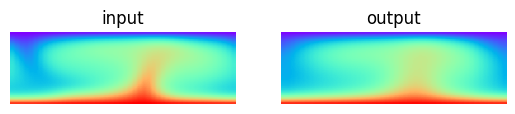

In [11]:
auto_encoder_animation(slice=24, fps=30, frames=1000, feature=FEATURE, 
                       axis=0, anim_dir=anim_dir, anim_name='width.mp4', 
                       model=model, sim_file=sim_file, device=DEVICE)


Video(os.path.join(anim_dir, 'width.mp4'))

**Depth slice**

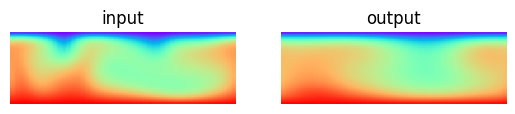

In [12]:
auto_encoder_animation(slice=24, fps=30, frames=1000, feature=FEATURE, 
                       axis=1, anim_dir=anim_dir, anim_name='depth.mp4', 
                       model=model, sim_file=sim_file, device=DEVICE)

Video(os.path.join(anim_dir, 'depth.mp4'))

**Height slice**

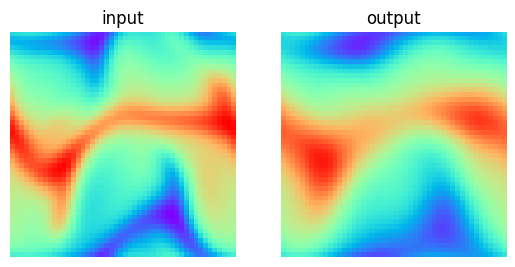

In [13]:
auto_encoder_animation(slice=16, fps=30, frames=1000, feature=FEATURE, 
                       axis=2, anim_dir=anim_dir, anim_name='height.mp4', 
                       model=model, sim_file=sim_file, device=DEVICE)

Video(os.path.join(anim_dir, 'height.mp4'))